In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
root_dir = './data/'
img_path = root_dir + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
train_dir = img_path + 'train'
test_dir = img_path + 'test'

In [3]:
metadata = pd.read_csv(os.path.join(root_dir, 'Chest_xray_Corona_Metadata.csv'))
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
metadata.describe()

,Unnamed: 0
count,5910.000000
mean,2957.075635
std,1710.186149
min,0.000000
25%,1477.250000
50%,2954.500000
75%,4431.750000
max,5932.000000


In [5]:
# count null values
for c in metadata.columns:
    print('Number of empty/missing values on column {}: {}'.format(c, metadata[c].isnull().sum()))

Number of empty/missing values on column Unnamed: 0: 0
Number of empty/missing values on column X_ray_image_name: 0
Number of empty/missing values on column Label: 0
Number of empty/missing values on column Dataset_type: 0
Number of empty/missing values on column Label_2_Virus_category: 5841
Number of empty/missing values on column Label_1_Virus_category: 1576


In [6]:
# replace those empty values by a default value
metadata = metadata.fillna(value='unknown')
metadata.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

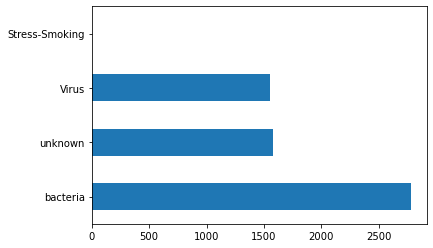

In [7]:
virus_category_1 = metadata['Label_1_Virus_category'].value_counts()
virus_category_1.plot(kind='barh')

plt.show()

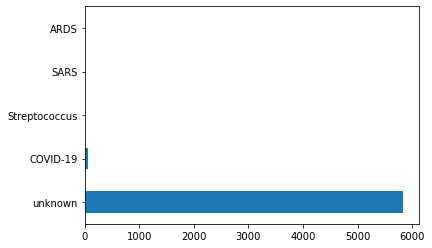

In [8]:
virus_category_2 = metadata['Label_2_Virus_category'].value_counts()
virus_category_2.plot(kind='barh')

plt.show()

<AxesSubplot:>

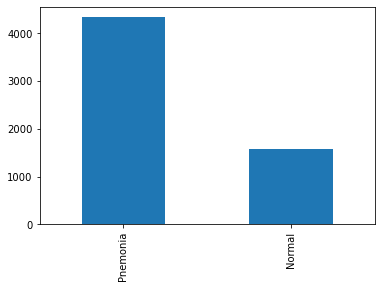

In [9]:
label = metadata['Label'].value_counts()
label.plot(kind='bar')

In [10]:
df_train = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

print('Training data:', df_train.shape)
print('Testing data:', df_test.shape)

Training data: (5286, 6)
Testing data: (624, 6)


In [11]:
df_train.loc[df_train['Label'].eq('Normal'), 'class'] = 'healthy'
df_train.loc[(df_train['class'].ne('healthy') & df_train['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['class'].ne('COVID-19')), 'class'] = 'COVID-19';

df_test.loc[df_test['Label'].eq('Normal'), 'class'] = 'healthy'
df_test.loc[(df_test['class'].ne('healthy') & df_test['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['class'].ne('COVID-19')), 'class'] = 'COVID-19';

print(df_train['class'].value_counts())
print(df_test['class'].value_counts())

COVID-19    3944
healthy     1342
Name: class, dtype: int64
COVID-19    390
healthy     234
Name: class, dtype: int64


C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
target_dict = {'healthy': 0, 'COVID-19': 1}
df_train['target'] = df_train['class'].map(target_dict)
df_test['target'] = df_test['class'].map(target_dict)

df_test.head()

<ipython-input-12-f44a5ec3c56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['class'].map(target_dict)
<ipython-input-12-f44a5ec3c56a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = df_test['class'].map(target_dict)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class,target
5286,5309,IM-0021-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5287,5310,IM-0019-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5288,5311,IM-0017-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5289,5312,IM-0016-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5290,5313,IM-0015-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0


In [13]:
print(df_train['target'].unique())
print(df_train['target'].unique() == df_test['target'].unique())

[0 1]
[ True  True]


In [14]:
def plot_img_hist(path, label, num_of_images):
    fig, ax = plt.subplots(num_of_images, 2, figsize=(15, 2.5*num_of_images))
    
    for i, file in enumerate(path):
        im = plt.imread(file)
        ax[i,0].imshow(im, cmap=plt.cm.bone)
        ax[i,1].hist(im.ravel(), 256, [0,256])
        ax[i,0].axis('off')
        
        if i == 0:
            ax[i,0].set_title('X-rays')
            ax[i,1].set_title('Histograms')
        
    fig.suptitle('Target: {}'.format(label), size=16)
    
    plt.show()
    
def display_img_hist(img_path, dset, split, label, num_of_images):
    path = dset[dset['class']==label]['X_ray_image_name'].values
    sample_path = path[:num_of_images]
    img_dir = img_path + split
#     print(img_dir)
    sample_path = list(map(lambda x: os.path.join(img_dir, x), sample_path))
#     print(sample_path)
    
    plot_img_hist(sample_path, label, num_of_images)

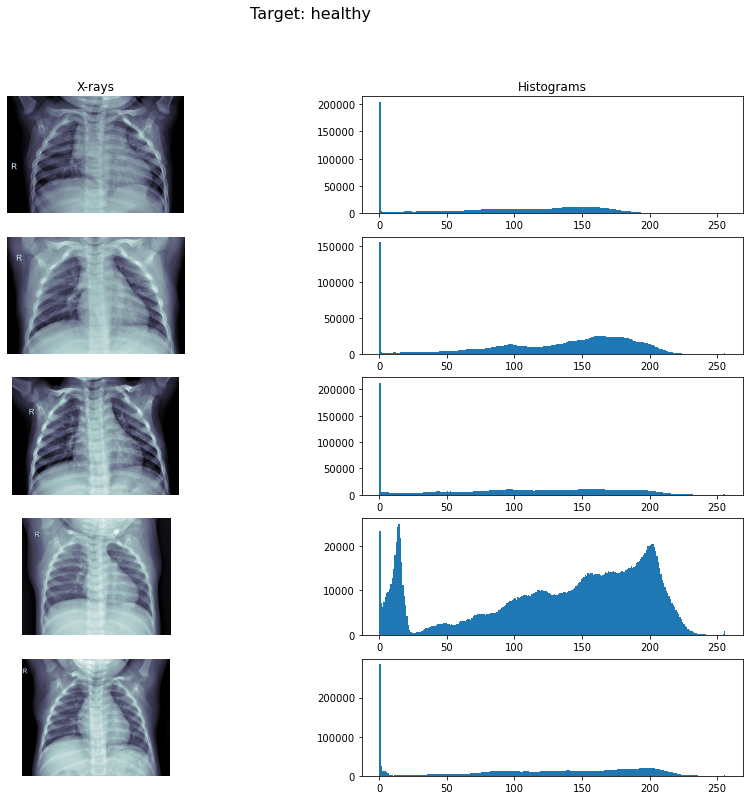

In [15]:
display_img_hist(img_path, df_train, 'train', 'healthy', 5)

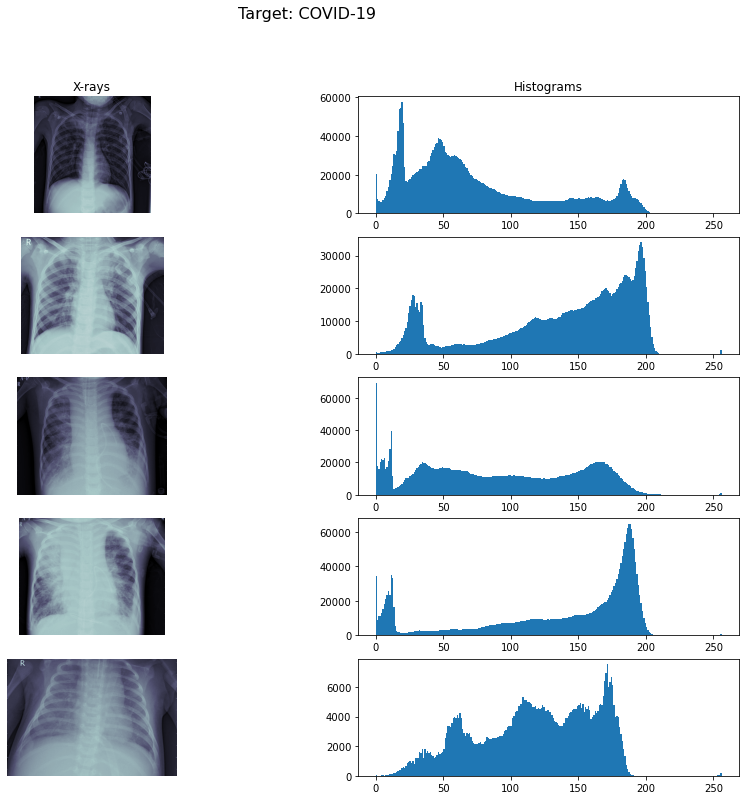

In [16]:
display_img_hist(img_path, df_train, 'train', 'COVID-19', 5)

In [17]:
class CoronaHackDataset(Dataset):
    
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        self.transform = transform
        self.list_dir = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        metadata = self.metadata.iloc[idx]
        fname = metadata['X_ray_image_name']
        
        try:
            file_idx = self.list_dir.index(fname)
        except:
            print('Image not found!')
            return None
        
        img_path = os.path.join(self.root_dir, self.list_dir[file_idx])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((128,128))
        tensor_img = self.transform(img)
        tensor_lbl = torch.tensor(metadata['target'].item())
        
        return tensor_img, tensor_lbl

In [18]:
batch_size = 32
normalize = False
stats = ((0.0093, 0.0093, 0.0092),(0.4827, 0.4828, 0.4828))

if normalize:
    train_tfms = torchvision.transforms.ToTensor()
else:
    train_tfms = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(128), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])
    
test_tfms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])

In [19]:
train_ds, val_ds = train_test_split(df_train, test_size=0.12, random_state=1, shuffle=True)
train_ds, val_ds = train_ds.reset_index(drop=True), val_ds.reset_index(drop=True)

In [20]:
print('Total data:', len(metadata))
print('--After splitting--')
print('Train: {}'.format(len(train_ds)))
print('Validation: {}'.format(len(val_ds)))
print('Test: {}'.format(len(df_test)))

Total data: 5910
--After splitting--
Train: 4651
Validation: 635
Test: 624


In [21]:
train_dataset = CoronaHackDataset(train_ds, train_dir, transform=train_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

valid_dataset = CoronaHackDataset(val_ds, train_dir, transform=test_tfms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_dataset = CoronaHackDataset(df_test, test_dir, transform=test_tfms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ModelBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def test_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        return loss
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch #{}: train_loss= {:.4f} | val_loss= {:.4f} | val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [23]:
# class BaselineModel(ModelBase):
    
#     def __init__(self):
#         super(BaselineModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        
#         self.pool = nn.MaxPool2d(2,2)
#         self.flatten = nn.Flatten()
#         self.relu = nn.ReLU()
        
#         self.linear1 = nn.Linear(2048*4*4, 512)
#         self.linear2 = nn.Linear(512, 128)
#         self.linear3 = nn.Linear(128, 4)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
#         x = F.relu(self.conv4(x))
#         x = self.pool(x)
#         x = F.relu(self.conv5(x))
#         x = self.pool(x)
# #         print(x.shape)
        
#         x = self.flatten(x)
# #         print(x.shape)
#         x = F.relu(self.linear1(x))
#         x = F.relu(self.linear2(x))
#         out = F.relu(self.linear3(x))
        
#         return out

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ModelBase):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(16), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [25]:
resnet9 = ResNet9(3, 4)
resnet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(num_epochs, max_lr, train_loader, val_loader, model,
          weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, save_path=''):
    
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
    
    for i in range(num_epochs):
        training_loss = 0.0
        val_loss = 0.0
        train_losses = []
        lrs = []
        
        # training phase
        model.train()
        for batch in train_loader:
#             data = data.to(torch.float32)
#             lbl = lbl.to(torch.long)
#             if use_cuda:
#                 data, lbl = data.cuda(), lbl.cuda()
            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
#             training_loss = training_loss + ((1/(batch+1)) * (loss.data - training_loss))
        
        # evaluation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        
        model.epoch_end(i+1, result)
        history.append(result)
    
    if len(save_path) > 0:
        torch.save(model.state_dict(), save_path)
    
    return history

In [30]:
load_saved_model = False
model = to_device(ResNet9(3, 2), device)
if load_saved_model:
    model.load_state_dict(torch.load('resnet9.pth'))

num_epochs = 5
lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam

In [31]:
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 0.6878196597099304, 'val_acc': 0.7752314805984497}]

In [32]:
history += train(num_epochs, lr, train_loader, valid_loader, model, 
                grad_clip=grad_clip, 
                weight_decay=weight_decay, 
                opt_func=optimizer,
                save_path='')

Epoch #1: train_loss= 0.2416 | val_loss= 0.1841 | val_acc: 0.9403
Epoch #2: train_loss= 0.1363 | val_loss= 0.0743 | val_acc: 0.9719
Epoch #3: train_loss= 0.0882 | val_loss= 0.1130 | val_acc: 0.9700
Epoch #4: train_loss= 0.0437 | val_loss= 0.0717 | val_acc: 0.9781
Epoch #5: train_loss= 0.0074 | val_loss= 0.0640 | val_acc: 0.9781


In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [35]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

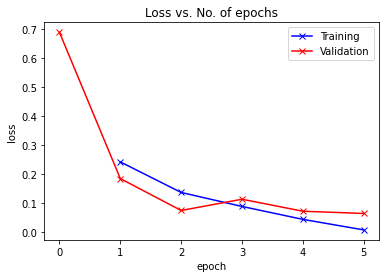

In [36]:
plot_losses(history)

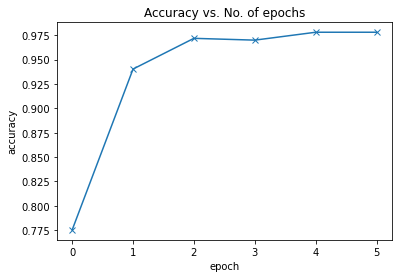

In [37]:
plot_accuracies(history)

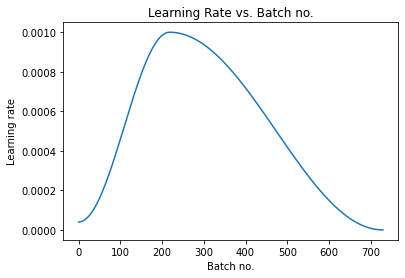

In [38]:
plot_lrs(history)

In [39]:
@torch.no_grad()
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    num_correct = 0
    
    preds = torch.tensor([])
    targets = torch.tensor([])
    for batch_idx, batch in enumerate(test_loader):
        images, labels = batch
        
        outputs = model(images)
        loss = model.test_step(batch)
        _, pred = torch.max(outputs, dim=1)
        
        preds = torch.cat((preds, pred), dim=0)
        targets = torch.cat((targets, labels), dim=0)
        
        test_loss = test_loss + ((1/(batch_idx+1)) * (loss.data - test_loss))
    
    for i in range(len(preds)):
        if preds[i] == targets[i]:
            num_correct += 1
        
    print('Test accuracy:', num_correct/len(preds))
    print('Test loss:', test_loss.item())
    return targets, preds

In [40]:
device = torch.device('cpu');
test_loader = DeviceDataLoader(test_loader, device);
model = to_device(model, device);

In [41]:
with torch.no_grad():
    targets, preds = test(model, test_loader)

Test accuracy: 0.7403846153846154
Test loss: 1.420113444328308


In [42]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.31      0.47       234
         1.0       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.65       624
weighted avg       0.82      0.74      0.69       624



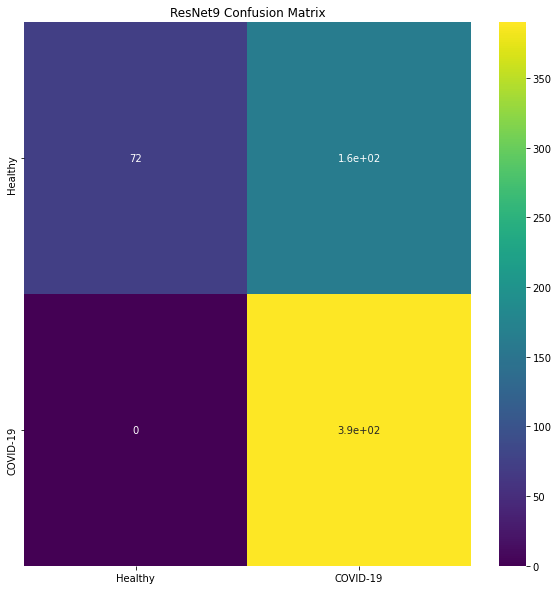

In [46]:
con_mat = confusion_matrix(targets, preds)
# con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,10))
plt.title('ResNet9 Confusion Matrix')
sns.heatmap(con_mat, cmap='viridis',
            yticklabels=['Healthy', 'COVID-19'],
            xticklabels=['Healthy', 'COVID-19'],
            annot=True);

In [49]:
con_mat

array([[ 72, 162],
       [  0, 390]], dtype=int64)

In [45]:
df_test['class'].unique()

array(['healthy', 'COVID-19'], dtype=object)